MLP model for predicting filtered shear stress and TTF using new features {freqQAmpI_filt, V_filt, maxFreqI_filt}

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
import time

from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input
from keras.utils import plot_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-2], data[end_ix-1, -2:]  #last column is assumed to be the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel(), 'TTF':data['TTF'].ravel()})  
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'T_pc':data['T_pc'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()}) 
df = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3787:136186].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3787:136186].ravel()})

df = pd.concat([df, df2], axis=1)

df = df[['freqQAmpI_filt', 'V_filt', 'maxFreqI_filt', 'SS', 'TTF']]
print("Input data:\n", df)

Input data:
         freqQAmpI_filt       V_filt  maxFreqI_filt        SS  TTF
0         31438.277060  5489.978529  457680.400524  5.656166  0.0
1         31421.341616  5489.981454  457727.638932  5.657157  0.0
2         31409.798761  5489.997639  457770.778724  5.658317  0.0
3         31398.815589  5490.007016  457811.889181  5.659499  0.0
4         31395.584981  5490.000189  457775.514596  5.660404  0.0
...                ...          ...            ...       ...  ...
132394    31041.955345  5459.380488  454414.128118  5.471059  0.0
132395    31035.059531  5459.377762  454404.028108  5.474545  0.0
132396    31020.001291  5459.388352  454403.709700  5.478286  0.0
132397    31012.016780  5459.398820  454398.871858  5.481751  0.0
132398    31010.874482  5459.399041  454410.333590  5.484813  0.0

[132399 rows x 5 columns]


In [ ]:
# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D (for input layer)

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132100, 300, 3)
Target shape, Y =  (132100, 2)
After reshaping, X =  (132100, 900)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 95112
Validation samples: 10568
Testing samples: 26420


Epoch 1/30
2973/2973 [==============================] - 13s 4ms/step - loss: 0.4797 - ss_loss: 0.2379 - ttf_loss: 0.4836 - val_loss: 0.1747 - val_ss_loss: 0.0614 - val_ttf_loss: 0.2266
Epoch 2/30
2973/2973 [==============================] - 13s 4ms/step - loss: 0.1069 - ss_loss: 0.0269 - ttf_loss: 0.1601 - val_loss: 0.0704 - val_ss_loss: 0.0073 - val_ttf_loss: 0.1263
Epoch 3/30
2973/2973 [==============================] - 12s 4ms/step - loss: 0.0739 - ss_loss: 0.0086 - ttf_loss: 0.1307 - val_loss: 0.0665 - val_ss_loss: 0.0090 - val_ttf_loss: 0.1151
Epoch 4/30
2973/2973 [==============================] - 14s 5ms/step - loss: 0.0633 - ss_loss: 0.0045 - ttf_loss: 0.1176 - val_loss: 0.0917 - val_ss_loss: 0.0044 - val_ttf_loss: 0.1746
Epoch 5/30
2973/2973 [==============================] - 13s 4ms/step - loss: 0.0579 - ss_loss: 0.0034 - ttf_loss: 0.1091 - val_loss: 0.0854 - val_ss_loss: 0.0034 - val_ttf_loss: 0.1641
Epoch 6/30
2973/2973 [==============================] - 13s 4ms/step - loss

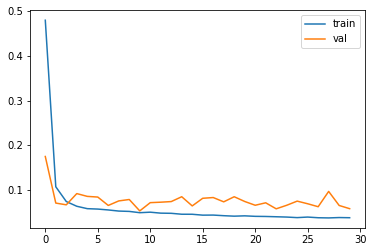

---Training time: 380.48691773 seconds ---


In [ ]:
# Build the model

np.random.seed(0)   # To get reproducible results
tf.random.set_seed(0)

out_dim = ydf.shape[1]

inp = Input(shape=in_dim, name='inp')
m = Dense(256, kernel_initializer = 'normal', activation='relu')(inp)
m = Dense(128, kernel_initializer = 'normal', activation='relu')(m)
m = Dense(32, kernel_initializer = 'normal', activation='relu')(m)
ss = Dense(1, kernel_initializer = 'normal', activation='linear', name='ss')(m)
ttf = Dense(1, kernel_initializer = 'normal', activation='relu', name='ttf')(m)
model = Model(inputs=[inp], outputs=[ss,ttf])

losses = {'ss': 'mse', 'ttf':'mse'}
losswts = {'ss': 1.0, 'ttf': 0.5}

model.compile(loss=losses, loss_weights=losswts, optimizer='adam')

start_time = time.time()
history = model.fit(X_train, {'ss':Y_train[:,0], 'ttf':Y_train[:,1]}, epochs=30, batch_size=32, 
                    validation_data=(X_val, {'ss':Y_val[:,0], 'ttf':Y_val[:,1]}), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


In [ ]:
# Evaluate the model

y_predTrain = model.predict(X_train)
ss_train_r2 = r2_score(Y_train[:,0], y_predTrain[0])
ss_train_rmse = np.sqrt(mean_squared_error(Y_train[:,0], y_predTrain[0]))
ttf_train_r2 = r2_score(Y_train[:,1], y_predTrain[1])
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train[:,1], y_predTrain[1]))

y_predVal = model.predict(X_val)
ss_val_r2 = r2_score(Y_val[:,0], y_predVal[0])
ss_val_rmse = np.sqrt(mean_squared_error(Y_val[:,0], y_predVal[0]))  
ttf_val_r2 = r2_score(Y_val[:,1], y_predVal[1])
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val[:,1], y_predVal[1]))

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
ss_test_r2 = r2_score(y_test[:,0], y_predTest[0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test[:,0], y_predTest[0]))
ttf_test_r2 = r2_score(y_test[:,1], y_predTest[1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test[:,1], y_predTest[1]))

print("Shear Stress\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_r2, ss_val_r2, ss_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_rmse, ss_val_rmse, ss_test_rmse))

print("\nTTF\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_r2, ttf_val_r2, ttf_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_rmse, ttf_val_rmse, ttf_test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

Shear Stress
R2 scores: Train - 0.92730, Validation - 0.91678, Test - 0.85945
RMSE scores: Train - 0.03466, Validation - 0.04257, Test - 0.05417

TTF
R2 scores: Train - 0.93700, Validation - 0.91558, Test - 0.85172
RMSE scores: Train - 0.26309, Validation - 0.33494, Test - 0.44219

---Time for Test data prediction: 1.06028700 seconds ---


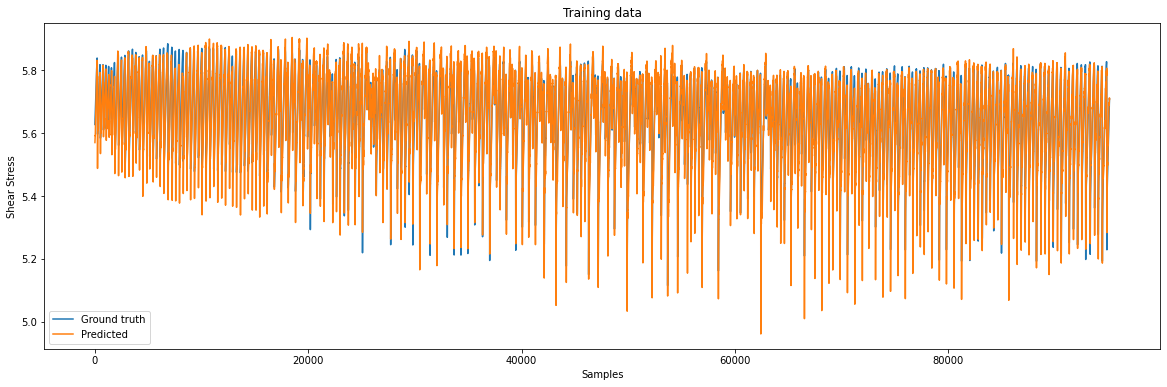

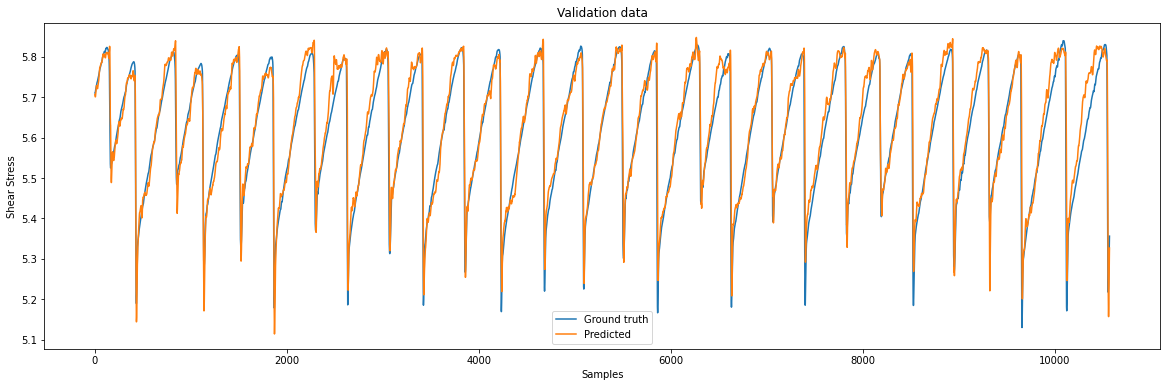

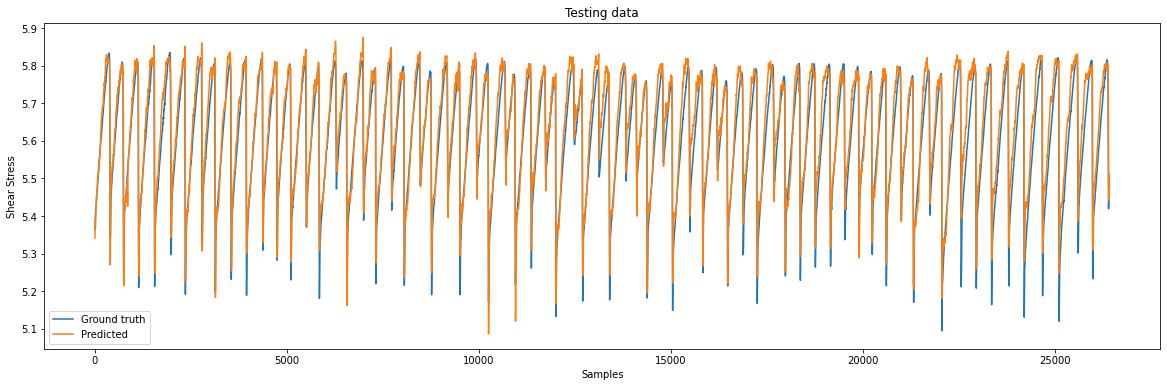

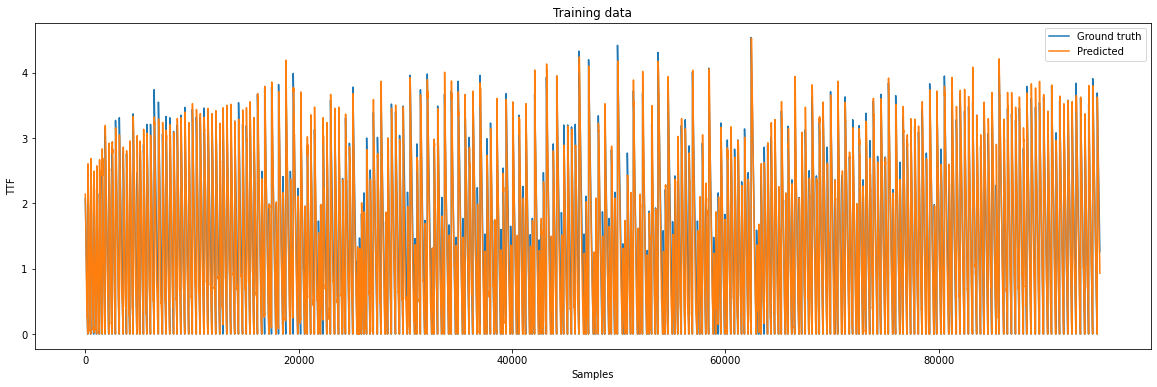

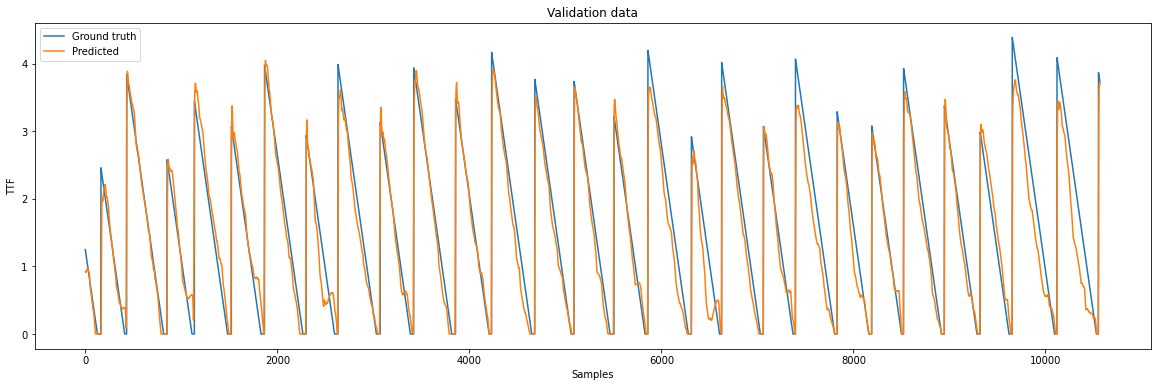

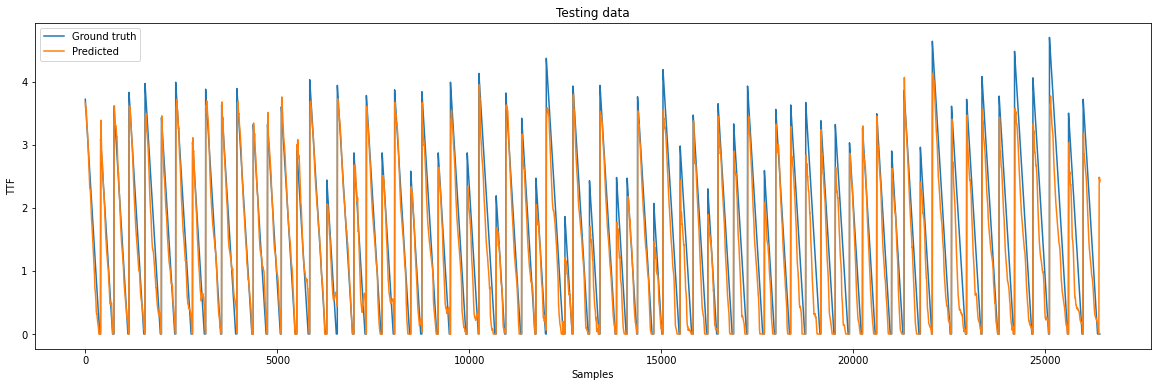

In [ ]:
# Results plot

def results_plot(fig_no, gt, pred, title, ylabel):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Samples')
  plt.ylabel(ylabel)
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train[:,0], y_predTrain[0], 'Training data', 'Shear Stress')
results_plot(2, Y_val[:,0], y_predVal[0], 'Validation data', 'Shear Stress')
results_plot(3, y_test[:,0], y_predTest[0], 'Testing data', 'Shear Stress')
results_plot(4, Y_train[:,1], y_predTrain[1], 'Training data', 'TTF')
results_plot(5, Y_val[:,1], y_predVal[1], 'Validation data', 'TTF')
results_plot(6, y_test[:,1], y_predTest[1], 'Testing data', 'TTF')

Text(0.5, 1.0, 'Detailed View, Testing Data')

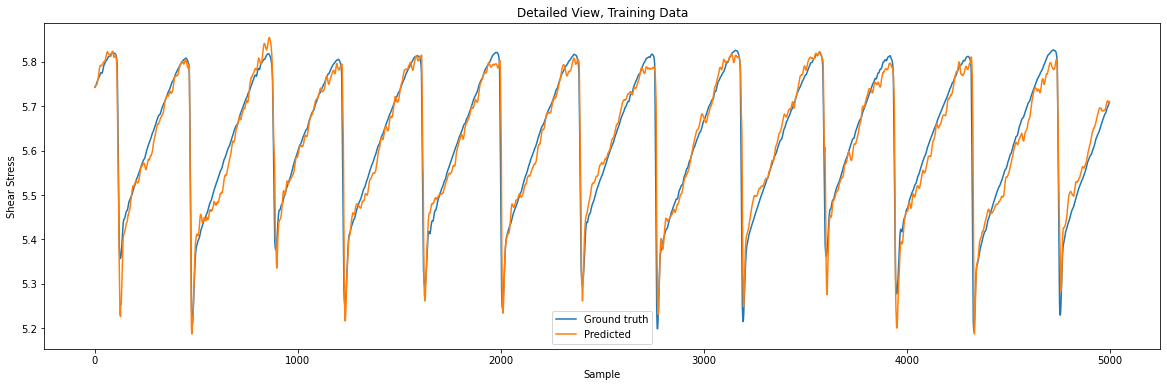

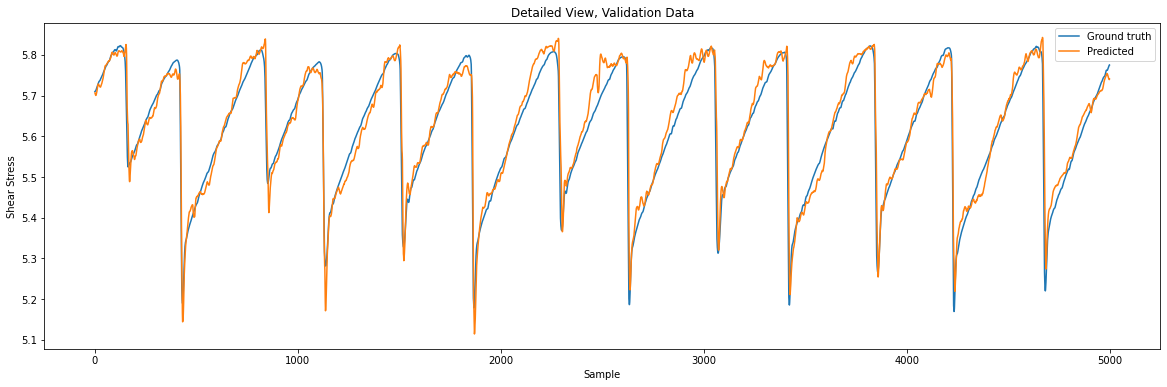

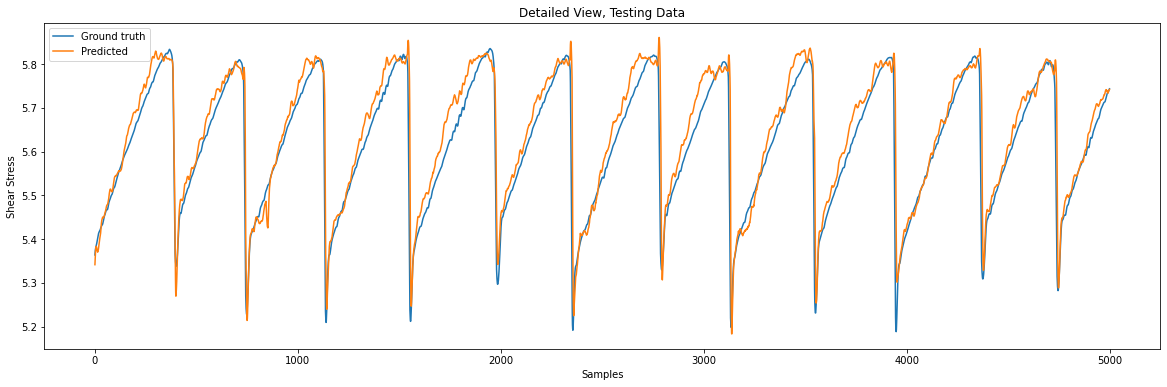

In [ ]:
# Detailed view of SS plots

n=5000

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-n:,0])
plt.plot(y_predTrain[0][-n:])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:n,0])
plt.plot(y_predVal[0][:n])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:n,0])
plt.plot(y_predTest[0][:n])
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'Detailed View, Testing Data')

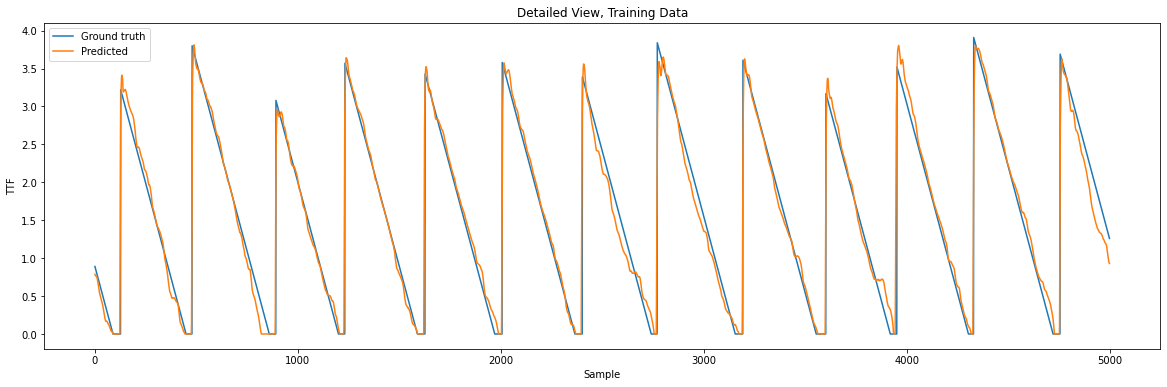

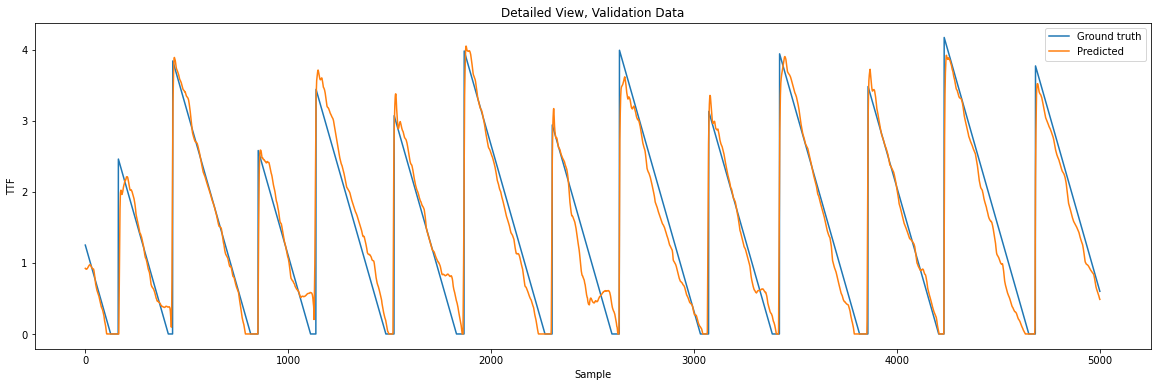

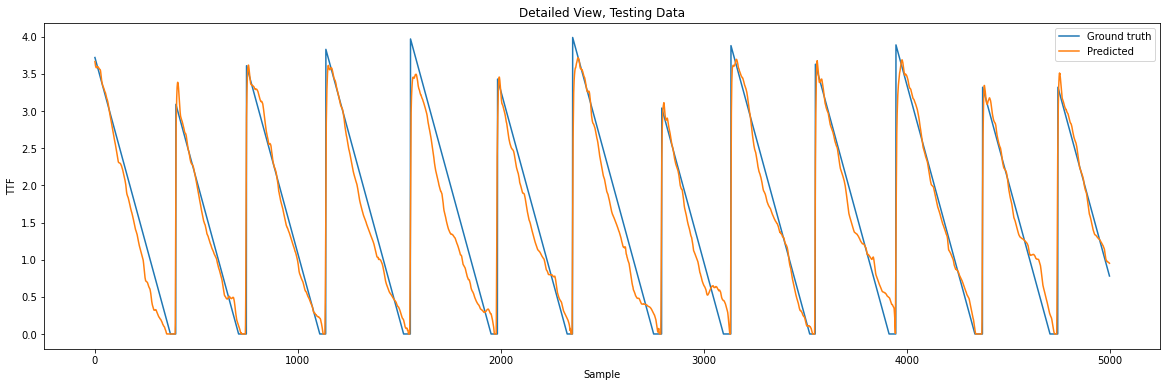

In [ ]:
# Detailed view of TTF plots

n=5000

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-n:,1])
plt.plot(y_predTrain[1][-n:])
plt.xlabel('Sample')
plt.ylabel('TTF')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:n,1])
plt.plot(y_predVal[1][:n])
plt.xlabel('Sample')
plt.ylabel('TTF')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:n,1])
plt.plot(y_predTest[1][:n])
plt.xlabel('Sample')
plt.ylabel('TTF')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'TTF')

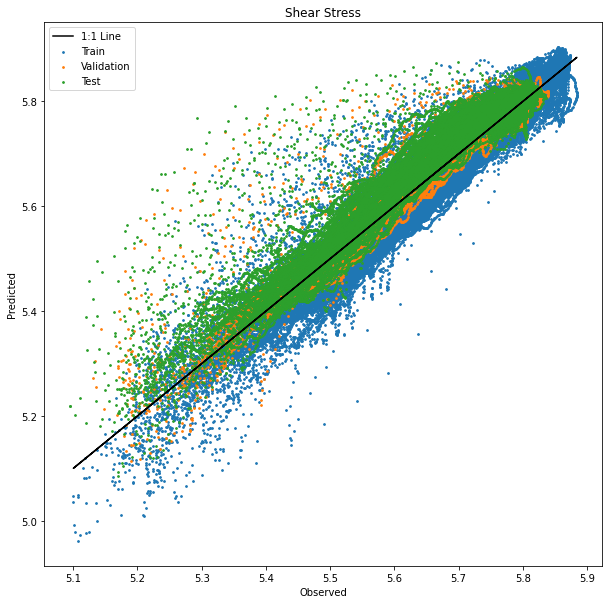

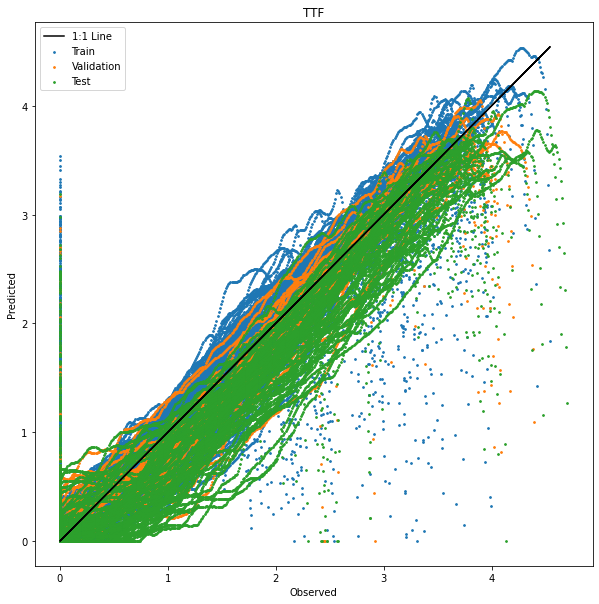

In [ ]:
# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train[:,0], Y_train[:,0], 'black')
plt.scatter(Y_train[:,0], y_predTrain[0], s=3)
plt.scatter(Y_val[:,0], y_predVal[0], s=3)
plt.scatter(y_test[:,0], y_predTest[0], s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('Shear Stress')

fig = plt.figure(8, figsize=(10,10))
plt.plot(Y_train[:,1], Y_train[:,1], 'black')
plt.scatter(Y_train[:,1], y_predTrain[1], s=3)
plt.scatter(Y_val[:,1], y_predVal[1], s=3)
plt.scatter(y_test[:,1], y_predTest[1], s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('TTF')
